In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# Configuration du modèle et des hyperparamètres

Dans la cellule suivante, nous définissons les principaux hyperparamètres pour l'entraînement :
- Nombre d'époques d'entraînement
- Taille des batchs
- Patience pour l'early stopping
- Taux d'apprentissage
- Choix du device (GPU/CPU)


In [10]:

# Configuration
num_epochs = 20
batch_size = 32
patience = 3
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device}")

Utilisation de cpu


# Prétraitement des données et chargement du dataset

- Dans la cellule suivante, nous effectuons plusieurs opérations importantes :
- Configuration des transformations pour l'augmentation des données (redimensionnement, rotations, etc.)
- Chargement des images et création des étiquettes
- Split des données en ensembles d'entraînement, validation et test
- Définition d'une classe Dataset personnalisée pour charger les images

In [11]:


transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [12]:

# Dataset path
dataset_path = 'C:\\Users\\sebas\\PycharmProjects\\malaria\\data\\images'
parasitized_dir = os.path.join(dataset_path, 'Parasitized')
uninfected_dir = os.path.join(dataset_path, 'Uninfected')

# Fichiers et étiquettes
parasitized_files = [os.path.join(parasitized_dir, f) for f in os.listdir(parasitized_dir) if f.endswith('.png')]
uninfected_files = [os.path.join(uninfected_dir, f) for f in os.listdir(uninfected_dir) if f.endswith('.png')]
parasitized_labels = [0] * len(parasitized_files)
uninfected_labels = [1] * len(uninfected_files)

all_files = parasitized_files + uninfected_files
all_labels = parasitized_labels + uninfected_labels


# Juste pour voir la distribution des dimensions des images

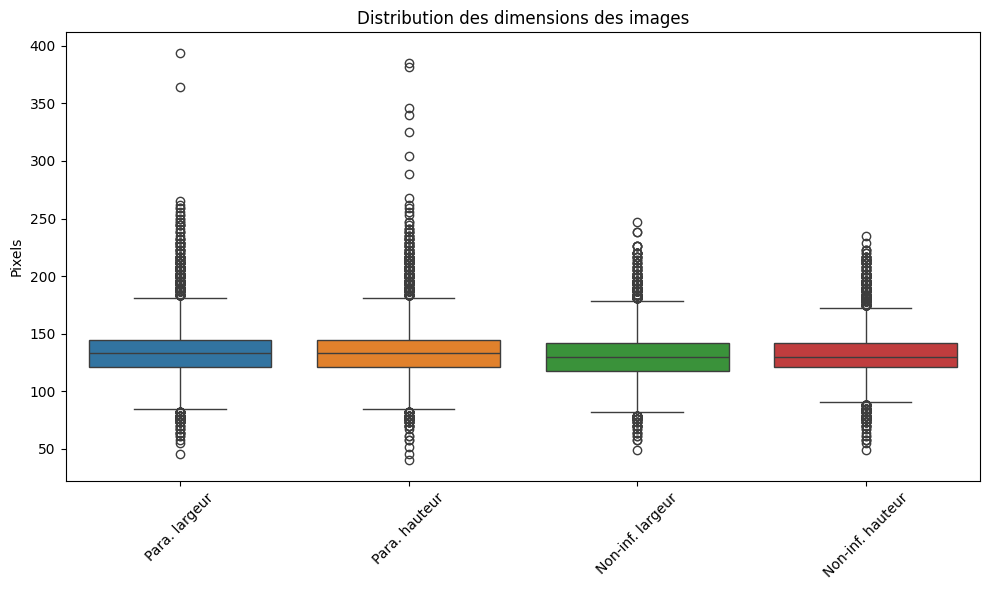


Statistiques des dimensions:
Dimension médiane (parasitées): 133x133
Dimension médiane (non infectées): 130x130


In [24]:
# Imports pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Création de listes pour stocker les dimensions
parasitized_widths = []
parasitized_heights = []
uninfected_widths = []
uninfected_heights = []

# Collecte des dimensions
for img_path in parasitized_files:
    with Image.open(img_path) as img:
        w, h = img.size
        parasitized_widths.append(w)
        parasitized_heights.append(h)

for img_path in uninfected_files:
    with Image.open(img_path) as img:
        w, h = img.size
        uninfected_widths.append(w)
        uninfected_heights.append(h)

# Création du boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[
    parasitized_widths, parasitized_heights,
    uninfected_widths, uninfected_heights
])
plt.xticks(range(4), ['Para. largeur', 'Para. hauteur', 'Non-inf. largeur', 'Non-inf. hauteur'], rotation=45)
plt.title('Distribution des dimensions des images')
plt.ylabel('Pixels')
plt.tight_layout()
plt.show()

# Affichage des statistiques
print("\nStatistiques des dimensions:")
print(f"Dimension médiane (parasitées): {int(np.median(parasitized_widths))}x{int(np.median(parasitized_heights))}")
print(f"Dimension médiane (non infectées): {int(np.median(uninfected_widths))}x{int(np.median(uninfected_heights))}")


# Distribution des valeurs moyennes dans les canaux de couleurs RGB

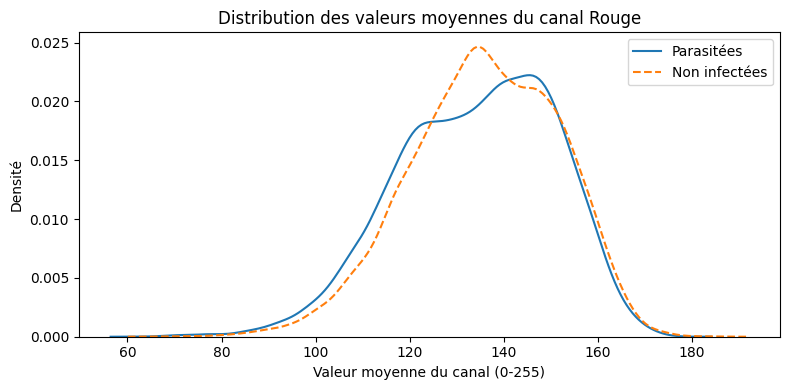

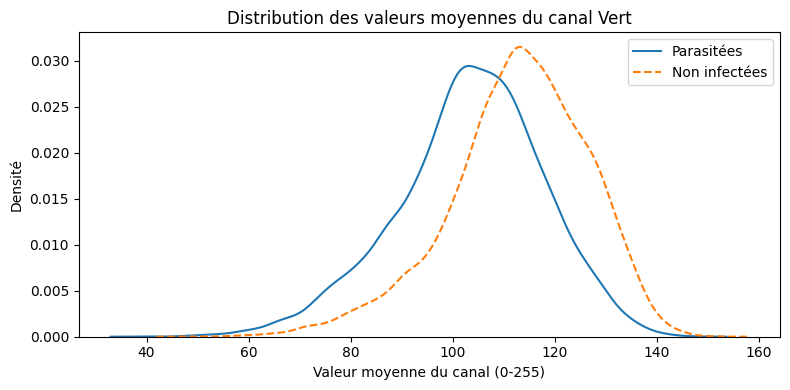

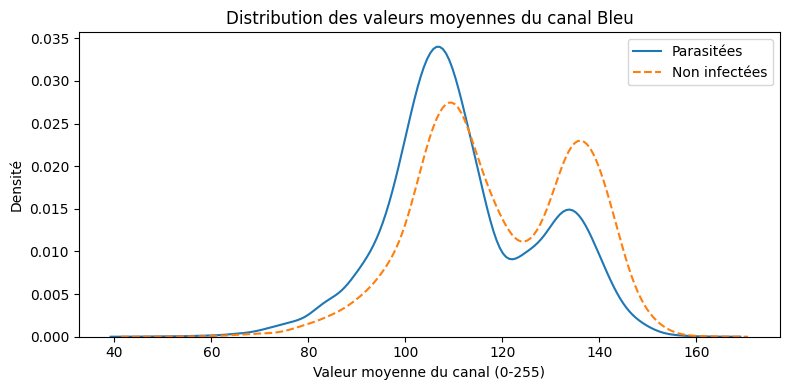

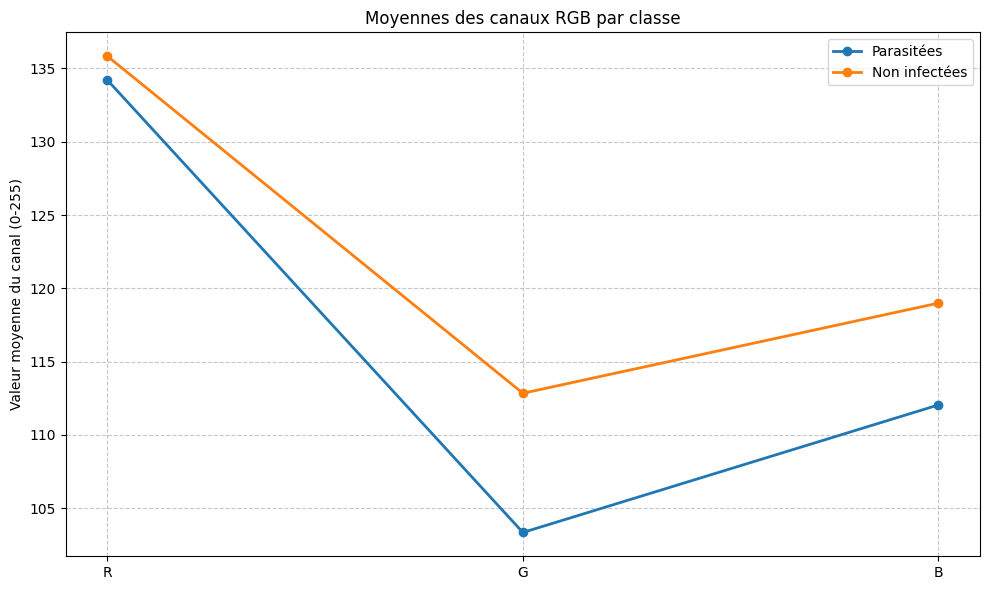

In [22]:
# Création des graphiques pour chaque canal RGB
canaux = ['R', 'G', 'B']
titres = ['Rouge', 'Vert', 'Bleu']

for canal, titre in zip(canaux, titres):
    plt.figure(figsize=(8, 4))
    
    # Tracer les courbes de densité
    sns.kdeplot(data=parasitized_rgb[canal], label='Parasitées', linestyle='-')
    sns.kdeplot(data=uninfected_rgb[canal], label='Non infectées', linestyle='--')
    
    plt.title(f'Distribution des valeurs moyennes du canal {titre}')
    plt.xlabel('Valeur moyenne du canal (0-255)')
    plt.ylabel('Densité')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Création d'un graphique montrant l'évolution des moyennes
plt.figure(figsize=(10, 6))

# Position des barres sur l'axe x
x = np.arange(3)
width = 0.35

# Calcul des moyennes
para_means = [np.mean(parasitized_rgb[c]) for c in canaux]
uninf_means = [np.mean(uninfected_rgb[c]) for c in canaux]

# Création des courbes
plt.plot(x, para_means, 'o-', label='Parasitées', linewidth=2)
plt.plot(x, uninf_means, 'o-', label='Non infectées', linewidth=2)

plt.title('Moyennes des canaux RGB par classe')
plt.xticks(x, ['R', 'G', 'B'])
plt.ylabel('Valeur moyenne du canal (0-255)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Split des données
 
Dans la cellule suivante, nous effectuons la séparation des données en trois ensembles :
- Un ensemble de test (20% des données)
- Un ensemble d'entraînement et de validation (80% des données), qui est ensuite divisé en :
- Un ensemble d'entraînement (64% du total)
- Un ensemble de validation (16% du total)
 
Nous utilisons un split stratifié pour conserver les proportions de chaque classe.
Nous définissons également une classe Dataset personnalisée pour charger les images.


In [14]:

# Split stratifié test (20%)
#  Ici, on divise all_files (les chemins vers les images) et all_labels (leurs étiquettes) en :
# - trainval_files, trainval_labels : 80% des données (train + val)
# - test_files, test_labels : 20% des données pour le test final
# - stratify=all_labels : permet un split stratifié, c’est-à-dire que la proportion de chaque classe reste la même dans chaque sous-ensemble (utile en cas de classes déséquilibrées).
trainval_files, test_files, trainval_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Split val à partir de train_val (20% de train_val)
#  On divise les 80% restants (trainval) en :
# - train_files : 64% (80% de 80%)
# - val_files : 16% (20% de 80%)
train_files, val_files, train_labels, val_labels = train_test_split(
    trainval_files, trainval_labels, test_size=0.2, stratify=trainval_labels, random_state=42
)

# Dataset personnalisé
class MalariaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


Dans la cellule suivante, nous définissons l'architecture de notre CNN personnalisé. Le modèle comprend :
- 3 couches de convolution avec des filtres de taille 3x3 et un padding de 1
- Des couches de pooling pour réduire la dimension spatiale
- Une couche fully connected avec 128 neurones
- Une couche de dropout pour éviter le surapprentissage 
- Une couche de sortie avec 2 neurones (classification binaire)


In [15]:
# Définition d'un modèle de réseau de neurones pour classer des images (cellule malade ou saine)
class CNNMalariaModel(nn.Module):
    def __init__(self, num_classes=2):  # On précise qu'on veut classer en 2 catégories (cellule malade ou saine)
        super(CNNMalariaModel, self).__init__()  # Initialisation du modèle à partir de la classe de base nn.Module

        # 1ère couche de convolution : elle regarde des petits morceaux de l'image grâce au kernel 3x3
        # Elle transforme les 3 canaux de couleur (rouge, vert, bleu) en 32 "cartes de caractéristiques"
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Normalise les valeurs pour aider le réseau à apprendre plus vite

        # 2ème couche : prend les 32 cartes et en crée 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 3ème couche : transforme les 64 cartes en 128 cartes
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # MaxPool : réduit la taille des images de moitié à chaque fois (comme un zoom arrière)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # GAP (Global Average Pooling) : réduit chaque carte à une seule valeur moyenne
        # Cela permet au modèle d’accepter des images de tailles différentes
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # 1ère couche entièrement connectée : prend les 128 valeurs et en fait 128 nouvelles
        self.fc1 = nn.Linear(128, 128)

        # Dropout : coupe certaines connexions au hasard pendant l'entraînement (pour éviter que le réseau ne "triche")
        self.dropout = nn.Dropout(0.5)

        # Dernière couche : donne 2 valeurs, une pour chaque classe (ex : "malade" et "saine")
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):  # C’est ici qu’on décrit comment les données traversent le réseau
        # Étape 1 : première convolution + normalisation + activation (ReLU = garde les valeurs positives)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Étape 2 : deuxième convolution + normalisation + activation + réduction de taille
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Étape 3 : troisième convolution + normalisation + activation + réduction de taille
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Réduction à une seule valeur par carte (grâce à GAP)
        x = self.gap(x)  # Résultat : un petit tableau de forme [batch, 128, 1, 1]

        # On "aplatie" ce petit tableau en une ligne pour le donner à la couche suivante
        x = x.view(x.size(0), -1)  # Devient [batch, 128]

        # Première couche complètement connectée avec ReLU
        x = F.relu(self.fc1(x))

        # Application du dropout (pendant l'entraînement uniquement)
        x = self.dropout(x)

        # Dernière couche qui donne 2 scores (un pour chaque classe)
        x = self.fc2(x)

        # Pas besoin d'ajouter Softmax ici : la fonction de perte CrossEntropy s'en occupe
        return x


Dans la cellule suivante, nous créons les datasets et dataloaders pour l'entraînement, la validation et le test.
Nous initialisons également le modèle, définissons la fonction de perte (CrossEntropyLoss) et l'optimiseur (Adam).
Nous implémentons aussi une fonction d'évaluation qui calcule la perte et l'exactitude sur un jeu de données.
Enfin, nous mettons en place la boucle d'entraînement avec early stopping pour éviter le surapprentissage.


In [16]:

# Datasets & Loaders
train_dataset = MalariaDataset(train_files, train_labels, transform=transform_train)
val_dataset = MalariaDataset(val_files, val_labels, transform=transform_train)
test_dataset = MalariaDataset(test_files, test_labels, transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modèle
model = CNNMalariaModel().to(device)

# Loss et optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Fonction d'évaluation
Dans la cellule suivante, nous définissons une fonction d'évaluation `evaluate()` qui permet de calculer la perte et l'exactitude du modèle sur un jeu de données donné. Cette fonction sera utilisée pour évaluer les performances du modèle sur les ensembles de validation et de test. Elle prend en paramètres le modèle et un dataloader, et retourne la perte moyenne et le pourcentage de prédictions correctes.


In [17]:

# Fonction d'évaluation
def evaluate(model, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # En phase d’évaluation (inférence), on n’a pas besoin de calculer les gradients, car on n’entraîne pas le modèle. Cela permet de réduire la consommation de mémoire.

        # On parcourt toutes les batchs fournies par le dataloader
        for images, labels in dataloader:
            # On déplace les données (images et labels) sur le device spécifié (CPU ou GPU)
            images, labels = images.to(device), labels.to(device)

            # On effectue la propagation avant (forward pass) pour obtenir les prédictions du modèle
            outputs = model(images)

            # On calcule la perte (loss) entre les prédictions du modèle et les labels réels
            loss = criterion(outputs, labels)

            # On ajoute la valeur de la perte courante (sous forme de nombre Python) à la perte cumulée
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total


# Variables pour l'entraînement
- best_acc : stocke la meilleure exactitude obtenue sur l'ensemble de validation
- patience_counter : compte le nombre d'époques sans amélioration pour l'early stopping
- best_model_state : sauvegarde l'état du meilleur modèle
Nous créons également un dossier 'models' pour sauvegarder les checkpoints du modèle.


In [18]:

# Entraînement
best_acc = 0.0
patience_counter = 0
best_model_state = None
os.makedirs('models', exist_ok=True)


# Entraînement du modèle. Pour chaque époque :
- Nous calculons la perte et l'exactitude sur l'ensemble d'entraînement
- Nous évaluons le modèle sur l'ensemble de validation
- Nous sauvegardons le meilleur modèle si l'exactitude de validation s'améliore
- Nous appliquons l'early stopping si aucune amélioration n'est constatée pendant plusieurs époques
Une barre de progression tqdm affiche l'avancement de l'entraînement avec les métriques en temps réel.

In [19]:

for epoch in range(num_epochs): # On boucle sur le nombre d'époques définies (num_epochs). Une époque = 1 passage complet sur tout le dataset d'entraînement.

    # On initialise les compteurs pour calculer la loss moyenne et la précision (accuracy) pendant cette époque.
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'\nEpoch [{epoch+1}/{num_epochs}]') # Affiche la progression globale du training.
    print('-' * 50)

    model.train() # Très important : active certains comportements spécifiques à l'entraînement (comme le Dropout ou BatchNorm).
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') # 
    for images, labels in pbar: # Itère sur les mini-batches d'entraînement avec une barre de progression grâce à tqdm.
        images, labels = images.to(device), labels.to(device) # Déplacement des données sur le device choisi (cuda ou cpu).
        outputs = model(images) # Calcul des prédictions du modèle sur le batch.
        loss = criterion(outputs, labels) # On compare les prédictions aux vraies étiquettes avec une fonction de perte. Ici c'est la Cross Entropy Loss.

        optimizer.zero_grad() # On remet à zéro les gradients précédents.
        loss.backward() # On calcule les gradients (Backpropagation)
        optimizer.step() # Mise à jour des poids du modèle selon les gradients.

        # On récupère les classes prédites et on met à jour le nombre de bonnes prédictions pour calculer l'accuracy.
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Mise à jour dynamique de la barre de progression avec les métriques du batch.
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    # On calcule la Loss et l'Accuracy globale de l'époque
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    val_loss, val_acc = evaluate(model, val_loader) # Évaluation du modèle sur les données de validation (fonction evaluate() externe).
    print(f'\nEpoch terminé: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_acc > best_acc: # Si le score de validation est meilleur que le précédent, on sauvegarde le modèle.
        best_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, 'models/best_model_cnn.pth')
        print(f'✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de {best_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'Patience: {patience_counter}/{patience}')
        if patience_counter >= patience: # Si la validation n'améliore plus pendant un certain nombre d’époques (patience), on arrête l'entraînement prématurément.
            print(f'\n⏹️ Early stopping après {epoch + 1} epochs sans amélioration.')
            break

# Évaluation finale
print("\n📊 Évaluation finale sur le test set :")
model.load_state_dict(best_model_state)
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')



Epoch [1/20]
--------------------------------------------------


Epoch 1/20: 100%|██████████| 552/552 [03:25<00:00,  2.69it/s, loss=0.3517, acc=85.16%]



Epoch terminé: Train Loss: 0.3673, Train Acc: 85.16% | Val Loss: 0.2183, Val Acc: 92.06%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 92.06%

Epoch [2/20]
--------------------------------------------------


Epoch 2/20: 100%|██████████| 552/552 [03:14<00:00,  2.83it/s, loss=0.1763, acc=92.66%]



Epoch terminé: Train Loss: 0.2214, Train Acc: 92.66% | Val Loss: 0.1773, Val Acc: 94.10%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 94.10%

Epoch [3/20]
--------------------------------------------------


Epoch 3/20: 100%|██████████| 552/552 [03:44<00:00,  2.46it/s, loss=0.3113, acc=93.61%]



Epoch terminé: Train Loss: 0.1984, Train Acc: 93.61% | Val Loss: 0.1761, Val Acc: 94.94%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 94.94%

Epoch [4/20]
--------------------------------------------------


Epoch 4/20: 100%|██████████| 552/552 [04:28<00:00,  2.05it/s, loss=4.2953, acc=94.41%]



Epoch terminé: Train Loss: 0.1892, Train Acc: 94.41% | Val Loss: 0.1719, Val Acc: 94.44%
Patience: 1/3

Epoch [5/20]
--------------------------------------------------


Epoch 5/20: 100%|██████████| 552/552 [04:35<00:00,  2.00it/s, loss=0.2212, acc=94.38%]



Epoch terminé: Train Loss: 0.1821, Train Acc: 94.38% | Val Loss: 0.1589, Val Acc: 94.69%
Patience: 2/3

Epoch [6/20]
--------------------------------------------------


Epoch 6/20: 100%|██████████| 552/552 [03:16<00:00,  2.80it/s, loss=0.0618, acc=94.87%]



Epoch terminé: Train Loss: 0.1650, Train Acc: 94.87% | Val Loss: 0.1536, Val Acc: 95.67%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 95.67%

Epoch [7/20]
--------------------------------------------------


Epoch 7/20: 100%|██████████| 552/552 [04:21<00:00,  2.11it/s, loss=4.0640, acc=94.91%]



Epoch terminé: Train Loss: 0.1727, Train Acc: 94.91% | Val Loss: 0.1463, Val Acc: 95.56%
Patience: 1/3

Epoch [8/20]
--------------------------------------------------


Epoch 8/20: 100%|██████████| 552/552 [03:45<00:00,  2.45it/s, loss=0.0100, acc=94.98%]



Epoch terminé: Train Loss: 0.1680, Train Acc: 94.98% | Val Loss: 0.1392, Val Acc: 95.85%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 95.85%

Epoch [9/20]
--------------------------------------------------


Epoch 9/20: 100%|██████████| 552/552 [03:21<00:00,  2.75it/s, loss=0.0055, acc=95.48%]



Epoch terminé: Train Loss: 0.1526, Train Acc: 95.48% | Val Loss: 0.1368, Val Acc: 95.69%
Patience: 1/3

Epoch [10/20]
--------------------------------------------------


Epoch 10/20: 100%|██████████| 552/552 [03:20<00:00,  2.75it/s, loss=0.0137, acc=95.41%]



Epoch terminé: Train Loss: 0.1530, Train Acc: 95.41% | Val Loss: 0.1459, Val Acc: 95.37%
Patience: 2/3

Epoch [11/20]
--------------------------------------------------


Epoch 11/20: 100%|██████████| 552/552 [03:42<00:00,  2.48it/s, loss=0.0134, acc=95.33%]



Epoch terminé: Train Loss: 0.1509, Train Acc: 95.33% | Val Loss: 0.1323, Val Acc: 96.05%
✅ Nouveau meilleur modèle sauvegardé avec une Val Acc de 96.05%

Epoch [12/20]
--------------------------------------------------


Epoch 12/20: 100%|██████████| 552/552 [03:45<00:00,  2.44it/s, loss=0.0815, acc=95.38%]



Epoch terminé: Train Loss: 0.1501, Train Acc: 95.38% | Val Loss: 0.1350, Val Acc: 95.83%
Patience: 1/3

Epoch [13/20]
--------------------------------------------------


Epoch 13/20: 100%|██████████| 552/552 [03:51<00:00,  2.39it/s, loss=0.2657, acc=95.42%]



Epoch terminé: Train Loss: 0.1470, Train Acc: 95.42% | Val Loss: 0.1319, Val Acc: 95.65%
Patience: 2/3

Epoch [14/20]
--------------------------------------------------


Epoch 14/20: 100%|██████████| 552/552 [03:48<00:00,  2.42it/s, loss=0.0352, acc=95.60%]



Epoch terminé: Train Loss: 0.1444, Train Acc: 95.60% | Val Loss: 0.1295, Val Acc: 95.94%
Patience: 3/3

⏹️ Early stopping après 14 epochs sans amélioration.

📊 Évaluation finale sur le test set :
Test Loss: 0.1301, Test Accuracy: 95.83%
